In [1]:
# ML app
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import numpy as np
from pathlib import Path
import inspect


In [3]:
# local kmer 
seq_features = pd.read_csv("sequence_posaware_features_ML2.csv")
seq_features = seq_features.fillna(0)

drop_cols = ["transcript_id", "label"]
X = seq_features.drop(columns=drop_cols, errors="ignore")
X = X.select_dtypes(include=["number"]) 

y = seq_features["label"]

In [5]:
# str + bpRNA classification features
str_features = pd.read_csv("bprna_ernie_features3.csv")

# drop noisy sample_id column
str_features = str_features.drop(columns=["sample_id"])

# rename sample_id_clean → sample_id for clarity
str_features = str_features.rename(columns={"sample_id_clean": "sample_id"})
# make str_fetaures label binary
str_features['label_str'] = str_features['label'].apply(lambda x: 1 if 'pos' in x.lower() else 0)

# overwrite label
str_features['label'] = str_features['label_str']
str_features = str_features.drop(columns=['label_str'])

In [6]:
str_features.head()

length  n_stems  n_hairpins  n_internal  n_multiloops  n_bulges  \
0   121.0        6           2           6             3         0   
1   121.0        3           2           2             0         0   
2   121.0        3           2           2             0         0   
3   121.0        5           2           4             3         0   
4   121.0        5           2           4             3         0   

   n_exterior  n_segments  n_pseudoknots  pk_total_bp  label  n_paired  \
0           2           3              4            4      0        20   
1           2           2              2            2      0        10   
2           2           2              2            2      0        12   
3           2           3              1            1      0        12   
4           2           3              1            1      0        14   

   paired_frac  central_paired                               sample_id  
0     0.165289               0    ENST00000420826:73178913-73179033(-)  
1     0.082645               0    ENST00000373232:71993091-71993211(-)  
2     0.099174               0    ENST00000534695:43343554-43343674(+)  
3     0.099174               1  ENST00000286713:124102758-124102878(-)  
4     0.115702               0  ENST00000367837:135286137-135286257(-)

In [7]:
# Merge them on
merged_df = pd.merge(
    seq_features,
    str_features,
    left_on='transcript_id',
    right_on='sample_id',
    how='inner'  # change to 'left' if you want to keep all seq entries
)

# drop duplicate label or id columns 
merged_df = merged_df.drop(columns=['sample_id'])  # if you only want 'transcript_id'

print(f"Merged shape: {merged_df.shape}")
print(merged_df[['transcript_id', 'label_x', 'label_y']].head(500)) # labels match so now I cna dleet one


Merged shape: (1396, 191)
                    transcript_id  label_x  label_y
0          NM_000152.5:256-376(+)        1        1
1          NM_000194.3:653-773(+)        1        1
2          NM_000391.4:543-663(+)        1        1
3        NM_000983.4:1051-1171(+)        1        1
4     NM_001002296.2:1833-1953(+)        1        1
..                            ...      ...      ...
495        NM_001769.4:525-645(+)        0        0
496  NM_001846.4:4787.5-4907.5(+)        0        0
497      NM_001873.4:1123-1243(+)        0        0
498      NM_001923.5:2938-3058(+)        0        0
499        NM_002079.3:318-438(+)        0        0

[500 rows x 3 columns]


In [8]:
merged_df = merged_df.drop(columns=['label_y'])

In [9]:
merged_df = merged_df.rename(columns={'label_x': 'label'})

In [10]:

print(merged_df[['transcript_id','label','length']].head()) # dleete some for ml

                 transcript_id  label  length
0       NM_000152.5:256-376(+)      1   121.0
1       NM_000194.3:653-773(+)      1   121.0
2       NM_000391.4:543-663(+)      1   121.0
3     NM_000983.4:1051-1171(+)      1   121.0
4  NM_001002296.2:1833-1953(+)      1   121.0


In [11]:
drop_cols = ["transcript_id", "length", "label", "label_str"]  # keep only numeric predictors

y = merged_df["label"].astype(int)

X = (
    merged_df
    .drop(columns=drop_cols, errors="ignore")
    .select_dtypes(include=["number"])   # safeguard
    .copy()
)

print("Final feature shape:", X.shape)
print("Target shape:", y.shape)



Final feature shape: (1396, 186)
Target shape: (1396,)


Seq-only: (1368, 174) Str-only: (1368, 12) Merged: (1368, 186) y: (1368,)


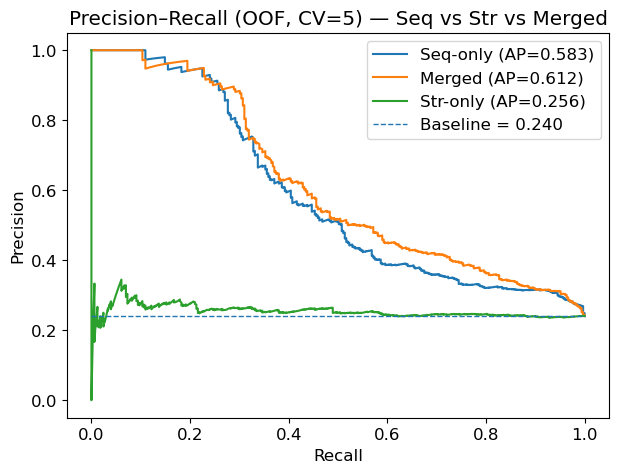

          avg_precision  accuracy  precision  recall      f1
Seq-only         0.5834    0.7807     0.5582  0.4225  0.4810
Merged           0.6121    0.7880     0.5747  0.4559  0.5085
Str-only         0.2556    0.5987     0.2545  0.3465  0.2934
Saved PR curve to: /nobackup/tjxz93/pse_project/pr_oof_seq_str_merged2.png


In [22]:
# y and three X matrices
# target
y = seq_features["label"].astype(int)

# seq-only predictors
X_seq = (
    seq_features
    .drop(columns=["transcript_id", "label"], errors="ignore")
    .select_dtypes(include=["number"])
    .copy()
)

# merged predictors (seq + str)
X_merge = (
    merged_df
    .drop(columns=["transcript_id", "length", "label", "label_str"], errors="ignore")
    .select_dtypes(include=["number"])
    .copy()
)

# str-only predictors: take merged and remove any seq-only columns
X_str = X_merge.drop(columns=X_seq.columns.intersection(X_merge.columns), errors="ignore").copy()

# align indices just in case
X_seq, X_merge, X_str, y = (
    X_seq.loc[y.index],
    X_merge.loc[y.index],
    X_str.loc[y.index],
    y.loc[y.index]
)

# handle NaN/inf
for _X in (X_seq, X_merge, X_str):
    _X.replace([np.inf, -np.inf], np.nan, inplace=True)
    _X.fillna(0, inplace=True)

print("Seq-only:", X_seq.shape, "Str-only:", X_str.shape, "Merged:", X_merge.shape, "y:", y.shape)

# Shared CV splits for all
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(X_seq, y))  # reuse for all datasets

def oof_pr_curves(X, y, splits):
    y_all, proba_all = [], []
    for (tr_idx, te_idx) in splits:
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # per-fold class weight
        pos = int((y_tr == 1).sum())
        neg = int((y_tr == 0).sum())
        spw = neg / max(pos, 1)

        model = make_model(spw)
        model.fit(X_tr, y_tr)

        proba = model.predict_proba(X_te)[:, 1]
        y_all.append(y_te.values)
        proba_all.append(proba)

    y_all = np.concatenate(y_all)
    proba_all = np.concatenate(proba_all)

    prec, rec, _ = precision_recall_curve(y_all, proba_all)
    ap = average_precision_score(y_all, proba_all)
    pred = (proba_all >= 0.5).astype(int)

    metrics = {
        "avg_precision": ap,
        "accuracy": accuracy_score(y_all, pred),
        "precision": precision_score(y_all, pred, zero_division=0),
        "recall": recall_score(y_all, pred, zero_division=0),
        "f1": f1_score(y_all, pred, zero_division=0),
    }
    return {"prec": prec, "rec": rec, "ap": ap, "metrics": metrics}

# run
results_seq   = oof_pr_curves(X_seq,   y, splits)
results_merge = oof_pr_curves(X_merge, y, splits)
results = {"Seq-only": results_seq, "Merged": results_merge}

# str-only only if we have columns left
if X_str.shape[1] > 0:
    results_str = oof_pr_curves(X_str, y, splits)
    results["Str-only"] = results_str
else:
    print(" No str-only columns detected after removing seq features; skipping str-only.")

# PR curves 
plt.rcParams.update({"figure.figsize": (7, 5), "font.size": 12})
fig, ax = plt.subplots()

for name, res in results.items():
    ax.plot(res["rec"], res["prec"], label=f"{name} (AP={res['ap']:.3f})")

# baseline = positive rate
pos_rate = y.mean()
ax.hlines(pos_rate, 0, 1, linestyles="dashed", linewidth=1, label=f"Baseline = {pos_rate:.3f}")

ax.set_title("Precision–Recall (OOF, CV=5) — Seq vs Str vs Merged")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="upper right")
plt.show()

# comparison table at threshold =  0.5
comp = pd.DataFrame({name: res["metrics"] for name, res in results.items()}).T.round(4)
print(comp)


# PR plot 
outdir = Path("/nobackup/tjxz93/pse_project")  
outdir.mkdir(parents=True, exist_ok=True)

png_path = outdir / "pr_oof_seq_str_merged2.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight", facecolor="white")  # save first
plt.show()        
plt.close(fig)   

print(f"Saved PR curve to: {png_path}")


In [23]:
#model = make_model(spw)
#model.fit(X_tr, y_tr) 
def keep_only_numeric(df):
    # always remove ids
    df = df.drop(columns=["transcript_id"], errors="ignore")
    # then keep only numeric/bool
    return df.select_dtypes(include=["number", "bool"]).copy()

X_seq   = keep_only_numeric(X_seq)
X_merge = keep_only_numeric(X_merge)
X_str   = keep_only_numeric(X_str)


def oof_pr_curves(X, y, splits, with_importance=False):
    y_all, proba_all = [], []
    fi_list = []  # collect per-fold importances if requested

    for (tr_idx, te_idx) in splits:
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pos = int((y_tr == 1).sum()) 
        neg = int((y_tr == 0).sum())
        spw = neg / max(pos, 1)

        model = make_model(spw)

        model.fit(X_tr, y_tr)  # model.fit 

        proba = model.predict_proba(X_te)[:, 1]
        y_all.append(y_te.values)
        proba_all.append(proba)

        if with_importance:
            fi_list.append(pd.Series(model.feature_importances_, index=X.columns))

    y_all = np.concatenate(y_all)
    proba_all = np.concatenate(proba_all)

    prec, rec, _ = precision_recall_curve(y_all, proba_all)
    ap = average_precision_score(y_all, proba_all)
    pred = (proba_all >= 0.5).astype(int)

    metrics = {
        "avg_precision": ap,
        "accuracy": accuracy_score(y_all, pred),
        "precision": precision_score(y_all, pred, zero_division=0),
        "recall": recall_score(y_all, pred, zero_division=0),
        "f1": f1_score(y_all, pred, zero_division=0),
    }

    mean_importance = None
    if with_importance and fi_list:
        mean_importance = pd.concat(fi_list, axis=1).mean(axis=1).sort_values(ascending=False)

    return {"prec": prec, "rec": rec, "ap": ap, "metrics": metrics, "importance": mean_importance}


In [24]:
results_seq   = oof_pr_curves(X_seq,   y, splits, with_importance=True)
results_merge = oof_pr_curves(X_merge, y, splits, with_importance=True)

# optional str-only
results = {"Seq-only": results_seq, "Merged": results_merge}
if X_str.shape[1] > 0:
    results["Str-only"] = oof_pr_curves(X_str, y, splits, with_importance=True)

# show top-15 features per dataset
for name, res in results.items():
    if res["importance"] is not None:
        print(f"\nTop features — {name}")
        print(res["importance"].head(15))



Top features — Seq-only
k2_pos1_AG     0.038018
k2_pos1_UC     0.032615
k2_pos0_UA     0.028153
k1_pos1_U      0.021754
k2_pos0_UU     0.016762
k1_pos1_A      0.014567
k2_pos1_UG     0.014275
k2_pos3_UU     0.013309
k1_pos-2_U     0.010405
k2_pos-4_UC    0.010256
k2_pos-2_CA    0.010193
k2_pos-3_GC    0.009946
k2_pos4_UG     0.009600
k1_pos2_G      0.009244
k2_pos2_UA     0.008339
dtype: float32

Top features — Merged
k2_pos1_UC     0.032745
k2_pos1_AG     0.030972
k1_pos1_A      0.030576
k2_pos0_UU     0.021568
k1_pos1_U      0.012558
k2_pos1_UG     0.011766
k2_pos3_UU     0.011221
k1_pos2_G      0.010941
k1_pos-2_U     0.010587
k2_pos-2_CA    0.010223
k2_pos-2_CU    0.009367
k2_pos2_UA     0.009332
k2_pos0_UA     0.008922
k2_pos1_CA     0.008772
k2_pos-2_CC    0.008540
dtype: float32

Top features — Str-only
n_exterior        0.115140
pk_total_bp       0.088634
central_paired    0.085355
n_paired          0.084940
n_segments        0.083407
n_internal        0.081933
n_multiloops   

In [29]:
# for shap

def _filter_kwargs(kwargs, fn):
    if not kwargs:
        return {}
    sig = inspect.signature(fn)
    return {k: v for k, v in kwargs.items() if k in sig.parameters}

def oof_shap_summary(
    X, y, splits, dataset_name="",
    outdir="shap_plots", prefix="", max_display=20,
    beeswarm_kwargs=None, bar_kwargs=None, subsample=None
):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    shap_vals_list, idx_list = [], []

    for (tr_idx, te_idx) in splits: # # iterate over stratified splits 
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx] # split
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx] 

        pos = int((y_tr == 1).sum())# number of positive/negative labels in training fold
        neg = int((y_tr == 0).sum())
        spw = neg / max(pos, 1)
        # set sample weight factor --> balance pos vs neg
        model = make_model(spw) # train
        model.fit(X_tr, y_tr)

        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X_te)  # (n_valid, n_features)
        shap_vals_list.append(shap_vals)
        idx_list.append(te_idx)

    # stack to OOF order
    oof_idx = np.concatenate(idx_list)
    shap_all = np.vstack(shap_vals_list)
    X_oof = X.iloc[oof_idx]

    # compute table (printed regardless of plotting)
    mean_abs = np.abs(shap_all).mean(axis=0)
    shap_imp = pd.Series(mean_abs, index=X.columns).sort_values(ascending=False)
    print(f"\nTop {max_display} mean |SHAP| — {dataset_name}")
    print(shap_imp.head(max_display))

    # subsample for plotting speed
    if subsample is not None and X_oof.shape[0] > subsample:
        rng = np.random.RandomState(42) # random seed
        take = rng.choice(X_oof.shape[0], size=subsample, replace=False) # randomly choose
        X_plot = X_oof.iloc[take]
        shap_plot = shap_all[take]
    else: # if no subsample requested or data already small
        X_plot = X_oof
        shap_plot = shap_all

    # Beeswarm
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_plot, X_plot,
        show=False, max_display=max_display,
        **_filter_kwargs(beeswarm_kwargs, shap.summary_plot)
    )
    beeswarm_path = Path(outdir) / f"{prefix}{dataset_name}_beeswarm.png"
    plt.title(f"SHAP Beeswarm — {dataset_name}")
    plt.savefig(beeswarm_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()

    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_plot, X_plot,
        plot_type="bar",
        show=False, max_display=max_display,
        **_filter_kwargs(bar_kwargs, shap.summary_plot)
    )
    bar_path = Path(outdir) / f"{prefix}{dataset_name}_bar.png"
    plt.title(f"SHAP Bar — {dataset_name}")
    plt.savefig(bar_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()

    return shap_imp, {"beeswarm": str(beeswarm_path), "bar": str(bar_path)}


In [30]:
# Seq-only
shap_seq, paths_seq = oof_shap_summary(
    X_seq, y, splits, dataset_name="Seq-only",
    outdir="shap_plots", prefix="seq_",
    max_display=20,
    beeswarm_kwargs={"cmap": "plasma", "alpha": 0.75},   # no dot_size
    bar_kwargs={"color": "darkorange"}
)
print(paths_seq)

# Merged
shap_merge, paths_merge = oof_shap_summary(
    X_merge, y, splits, dataset_name="Merged",
    outdir="shap_plots", prefix="merged_",
    beeswarm_kwargs={"cmap": "viridis", "alpha": 0.8},   # no dot_size
    bar_kwargs={"color": "teal"}
)
print(paths_merge)

# Str-only (if any)
if X_str.shape[1] > 0:
    shap_str, paths_str = oof_shap_summary(
        X_str, y, splits, dataset_name="Str-only",
        outdir="shap_plots", prefix="str_",
        beeswarm_kwargs={"cmap": "magma", "alpha": 0.8}, # no dot_size
        bar_kwargs={"color": "slateblue"}
    )
    print(paths_str)




Top 20 mean |SHAP| — Seq-only
k2_pos1_AG    0.472029
k1_pos1_U     0.366421
k2_pos1_UC    0.349204
dinuc_UU      0.244134
k1_pos-2_U    0.236441
dinuc_UG      0.225787
gc_content    0.182107
dinuc_AG      0.172642
dinuc_UA      0.169963
dinuc_AC      0.166869
perc_G        0.166441
dinuc_CU      0.165584
dinuc_AA      0.155269
dinuc_CC      0.149887
dinuc_GA      0.146653
perc_A        0.144731
perc_U        0.143749
dinuc_CA      0.133249
k1_pos1_A     0.124606
k2_pos1_UG    0.123362
dtype: float32
{'beeswarm': 'shap_plots/seq_Seq-only_beeswarm.png', 'bar': 'shap_plots/seq_Seq-only_bar.png'}

Top 20 mean |SHAP| — Merged
k2_pos1_AG    0.464272
k2_pos1_UC    0.345687
k1_pos1_U     0.305206
k1_pos-2_U    0.234524
k1_pos1_A     0.232233
dinuc_UU      0.212345
n_stems       0.180445
n_hairpins    0.176968
gc_content    0.167296
dinuc_UG      0.162338
perc_G        0.147824
dinuc_CC      0.145258
dinuc_CU      0.143294
perc_U        0.142131
dinuc_AC      0.141571
dinuc_AG      0.141136
di